#### Busqueda tipo waze/google maps

Nuestro objetivo es crear una heuristica creativa y util para  encontrar la mejor ruta entre dos lugares del municipio de Envigado   

PASO A PASO 
1. Librerías 
2. Inicialización del grafo  
  2.1  Creación del grafo  
  2.2  Creación de los nodos
3. Manipulación del grafo  
  3.1  Velocidades y travel time  
  3.2  Superficie 
  3.3  Variables adicionales 

4. Pesos  
  4.1 Peso de superficie y función  
  4.2 Pesos de variables adicionales  
  4.3 Heurística final 

5. Enrutamiento 
  5.1 Definición Start/End  
  5.2 Rutas
  
    - Definición de rutas  
    - Gráficas 
    - Comparaciones

   5.3 Funciones complementarias  



#### 1. Librerías 

In [81]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox

### 2 Grafo
#### 2.1 Creación del grafo 


In [ ]:
G = ox.graph_from_place('Medellin, Antioquia, Colombia', network_type='drive', simplify=False)

#### 2.2 Creación Nodos y Aristas 
Con esta función graph to *graph_to_gdfs(G)* traemos los nodos y aristas de nuestro grafo como un DF

In [83]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [54]:
gdf_edges.head()

osmid    highway lanes maxspeed  \
u         v          key                                         
309313450 414940715  0    1019189334  secondary     2       50   
          440765240  0    1019189334  secondary     2       50   
309313451 414940727  0    1019189334  secondary     2       50   
          414940715  0    1019189334  secondary     2       50   
309313454 4124260034 0    1019190824  secondary     2       60   

                                         name  oneway  reversed     length  \
u         v          key                                                     
309313450 414940715  0    Variante Las Palmas   False     False  24.138083   
          440765240  0    Variante Las Palmas   False      True  91.294214   
309313451 414940727  0    Variante Las Palmas   False     False  26.537531   
          414940715  0    Variante Las Palmas   False      True  27.314193   
309313454 4124260034 0    Variante Las Palmas   False     False  25.381809   

                          ref width junction bridge access  \
u         v          key                                     
309313450 414940715  0    NaN   NaN      NaN    NaN    NaN   
          440765240  0    NaN   NaN      NaN    NaN    NaN   
309313451 414940727  0    NaN   NaN      NaN    NaN    NaN   
          414940715  0    NaN   NaN      NaN    NaN    NaN   
309313454 4124260034 0    NaN   NaN      NaN    NaN    NaN   

                                                                   geometry  
u         v          key                                                     
309313450 414940715  0    LINESTRING (-75.51982 6.15843, -75.52004 6.15839)  
          440765240  0    LINESTRING (-75.51982 6.15843, -75.51903 6.15866)  
309313451 414940727  0     LINESTRING (-75.52028 6.1584, -75.52051 6.15847)  
          414940715  0     LINESTRING (-75.52028 6.1584, -75.52004 6.15839)  
309313454 4124260034 0     LINESTRING (-75.5215 6.15963, -75.52164 6.15981)

### 3. Manipulación del Df
Debemos tener las variables necesarias para poder hacer nuestra heuristica 

#### 3.1 Velocidades y travel time
 Vamos a llenar todas las velocidades para poder crear el travel time 


In [127]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

gdf_edges.head()

osmid      highway lanes maxspeed         name  \
u         v          key                                                       
309026269 5483069113 0     28136096    secondary     3       50     Calle 10   
309026271 404910004  0    570316480    secondary     3       50     Calle 10   
309026273 393988726  0     34939944    secondary     3       50     Calle 10   
          5531246241 0    913377168      primary     3      NaN  Carrera 43A   
309026274 5532356070 0    569672822  residential     1      NaN   Carrera 41   

                          oneway  reversed     length  speed_kph  travel_time  \
u         v          key                                                        
309026269 5483069113 0      True     False  76.702542  50.000000     5.522583   
309026271 404910004  0      True     False  42.866877  50.000000     3.086415   
309026273 393988726  0      True     False  12.333670  50.000000     0.888024   
          5531246241 0      True     False  11.669436  52.429525     0.801265   
309026274 5532356070 0      True     False   6.880701  30.656970     0.807990   

                         bridge junction width  ref access tunnel  \
u         v          key                                            
309026269 5483069113 0      NaN      NaN   NaN  NaN    NaN    NaN   
309026271 404910004  0      NaN      NaN   NaN  NaN    NaN    NaN   
309026273 393988726  0      NaN      NaN   NaN  NaN    NaN    NaN   
          5531246241 0      NaN      NaN   NaN  NaN    NaN    NaN   
309026274 5532356070 0      NaN      NaN   NaN  NaN    NaN    NaN   

                                                                   geometry  
u         v          key                                                     
309026269 5483069113 0    LINESTRING (-75.57393 6.21195, -75.57329 6.21168)  
309026271 404910004  0     LINESTRING (-75.57286 6.21152, -75.5725 6.21138)  
309026273 393988726  0    LINESTRING (-75.57052 6.21062, -75.57042 6.21059)  
          5531246241 0    LINESTRING (-75.57052 6.21062, -75.57056 6.21053)  
309026274 5532356070 0     LINESTRING (-75.56877 6.20997, -75.5688 6.20991)

#### 3.2 Altura Nodos
Importaremos la altura de los nodos para poder hacer el cálculo de la pendiente de las aristas 


#### 3.3 Superficie
Se importa desde features la superficie de las aristas  
Es importante resaltar la forma en que se junta gdf_surface con gdf_eges ya que en esta función se hace el manejo de los index para que el grafo se pueda actualizar de manera correcta 

In [ ]:
gdf_surface = ox.features.features_from_place("Medellin, Antioquia, Colombia", tags={'surface': True})

def add_surface_data(gdf_edges, gdf_surface):
    edges_with_surface = gdf_edges.copy()
    
    # Inicializar columna surface
    edges_with_surface['surface'] = 'asphalt'  # valor por defecto
    
    # Para cada feature de superficie, encontrar aristas que intersectan
    for idx, surface_feature in gdf_surface.iterrows():
        if pd.isna(surface_feature['surface']):
            continue
            
        # Encontrar aristas que intersectan con esta superficie
        mask = edges_with_surface.geometry.intersects(surface_feature.geometry)
        
        # Asignar el tipo de superficie
        edges_with_surface.loc[mask, 'surface'] = surface_feature['surface']
    
    return edges_with_surface


Verificación de los index y de cantidad de superficies 

In [ ]:
gdf_edgesMod = add_surface_data(gdf_edges, gdf_surface)

print("Índices originales:", gdf_edges.index.names)
print("Índices modificados:", gdf_edgesMod.index.names)
# Conteo por tipo de superficie
conteo = gdf_edgesMod['surface'].value_counts(dropna=False)
print(conteo)


Gsurface = ox.graph_from_gdfs(gdf_nodes, gdf_edgesMod)

Índices originales: ['u', 'v', 'key']
Índices modificados: ['u', 'v', 'key']
surface
asphalt            178679
unpaved             13505
concrete             7020
paved                6180
concrete:lanes       1256
paving_stones         506
gravel                362
dirt                  284
earth                 230
fine_gravel           162
ground                125
sett                   91
pebblestone            84
compacted              76
concrete:plates        62
grass                  48
cobblestone            34
grass_paver             8
sand                    4
wood                    2
Name: count, dtype: int64


#### 3.3 Variables adicionales 
- Hospitales 
- Parques 
- Escuelas 

Se adquieren las variables necesarias con su geometría, y con este dato se adjuntan a la arista más cercana 

In [128]:
gdf_hospitals = ox.features_from_place("Medellin", tags={'amenity': 'hospital'})
gdf_schools = ox.features_from_place("Medellin", tags={'amenity': 'school'})
gdf_parks = ox.features_from_place("Medellin", tags={'leisure': 'park'})

def add_proximity_features(Gsurface, gdf_features, feature_name, buffer_distance=0.001):
    for u, v, key, data in Gsurface.edges(keys=True, data=True):
        edge_geom = data['geometry']
        buffer_zone = edge_geom.buffer(buffer_distance)
         
        # Contar features cercanos
        nearby_features = gdf_features[gdf_features.geometry.intersects(buffer_zone)]
        count = len(nearby_features)
        
        # Añadir al grafo
        G[u][v][key][feature_name] = count

add_proximity_features(Gsurface, gdf_hospitals, 'nearby_hospitals')
add_proximity_features(Gsurface, gdf_schools, 'nearby_schools')
add_proximity_features(Gsurface, gdf_parks, 'crosses_park')

KeyboardInterrupt: 

Verificación de nuevas variables 

In [89]:
print("Hospitales encontrados:", len(gdf_hospitals))
print("Escuelas encontradas:", len(gdf_schools))
print("Parques encontrados:", len(gdf_parks))


# Ver si tienen geometría válida
if len(gdf_hospitals) > 0:
    print("Hospitales tienen geometría:", not gdf_hospitals.geometry.empty)
if len(gdf_schools) > 0:
    print("Escuelas tienen geometría:", not gdf_schools.geometry.empty)

Hospitales encontrados: 99
Escuelas encontradas: 836
Parques encontrados: 829
Hospitales tienen geometría: True
Escuelas tienen geometría: True


#### 3.4 Verificamos los nuevos atributos del grafo

In [124]:
gdf_nodes2, gdf_edges2 = ox.graph_to_gdfs(Gsurface)

In [125]:
gdf_edges2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 208718 entries, (np.int64(309026269), np.int64(5483069113), np.int64(0)) to (np.int64(13073433094), np.int64(13073433092), np.int64(0))
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   osmid             208718 non-null  int64   
 1   highway           208718 non-null  object  
 2   lanes             72818 non-null   object  
 3   maxspeed          23119 non-null   object  
 4   name              133452 non-null  object  
 5   oneway            208718 non-null  bool    
 6   reversed          208718 non-null  bool    
 7   length            208718 non-null  float64 
 8   speed_kph         208718 non-null  float64 
 9   travel_time       208718 non-null  float64 
 10  geometry          208718 non-null  geometry
 11  surface           208718 non-null  object  
 12  nearby_hospitals  208718 non-null  int64   
 13  nearby_schools    208718 non-null

### 4 Pesos (heurística)
#### 4.1 Pesos de superficie

In [ ]:
surface_weights = {
    'asphalt': 1.0,             
    'concrete': 1.1,
    'concrete:lanes': 1.1,
    'concrete:plates': 1.2,
    'paved': 1.2,
    'paving_stones': 1.4,
    'fine_gravel': 1.6,
    'gravel': 2.0,
    'cobblestone': 2.2,
    'ground': 2.5,
    'dirt': 3.0,
    'unpaved': 2.8,
    'unknown': 4 
}

def surface_weight(u, v, data):
    surface = data.get('surface', 'unknown')
    length = data.get('length', 1)
    factor = surface_weights.get(surface, 4.0)

    peso = length * factor
    return peso



#### 4.2 Pesos
- medical_emergency_weight: con este peso vamos a ir eligiendo el mejor camino para una emergencia médica o ambulancia  
   - tenemos en cuenta si estamos cerca a un hospital, la superficie, el ancho de la via y si es una via rapida 
- family_safe_weight: con este peso se calcula el mejor viaje en un caso familiar 
  - tenemos en cuenta la superficie, intentamos dar prioridad a vias residenciales y tambien la cercanía a parques y escuelas

In [ ]:
from datetime import datetime

TRIP_TYPES = ['medical', 'family']

def medical_emergency_weight(u, v, data):
  
    base_cost = data.get('length', 1)
    
    # Superficie 
    surface = data.get('surface', 'unknown')
    surface_factors = {
        'asphalt': 1.0, 'concrete': 1.0, 'paved': 1.2,
        'gravel': 3.0, 'unpaved': 4.0, 'unknown': 5.0
    }
    
    surface_factor = surface_factors.get(surface, 5.0)
    
    hospitals = data.get('nearby_hospitals', 0)
    hospital_bonus = 0.3 if hospitals > 0 else 1.0  
    
    # Penalizar calles muy estrechas
    lanes = data.get('lanes', '1')
    try:
        num_lanes = int(str(lanes).split(';')[0]) if lanes else 1
        lane_penalty = 1.0 if num_lanes >= 2 else 2.0  
    except:
        lane_penalty = 1.5
    
    # Bonificar carreteras principales
    highway_type = data.get('highway', '')
    highway_bonus = 0.8 if highway_type in ['primary', 'secondary', 'trunk'] else 1.0
    
    return base_cost * surface_factor * hospital_bonus * lane_penalty * highway_bonus
   
   
def family_safe_weight(u, v, data):

    base_cost = data.get('length', 1)
  
    surface = data.get('surface', 'unknown')
    surface_factors = {
        'asphalt': 1.0, 'concrete': 1.1, 'paved': 1.0,
        'gravel': 2.5, 'unpaved': 3.0, 'unknown': 2.0
    }
    surface_factor = surface_factors.get(surface, 2.0)
    
    highway_type = data.get('highway', '')
    if highway_type in ['industrial', 'trunk']:
        industrial_penalty = 3.0  # Evita fuertemente
    elif highway_type == 'residential':
        industrial_penalty = 0.8  # Prefiere residencial
    else:
        industrial_penalty = 1.0
    
    # Bonificar cercanía a escuelas (zona segura familiar)
    schools = data.get('nearby_schools', 0)
    school_bonus = 0.9 if schools > 0 else 1.0
    
    # Bonificar parques (zona familiar agradable)
    parks = data.get('crosses_park', 0)
    park_bonus = 0.85 if parks > 0 else 1.0
    
    return base_cost * surface_factor * industrial_penalty * school_bonus * park_bonus


#### 4.2 Heuristicas
Se crearon dos heuristicas para el algortimos a* donde se hace ver más cercanos a los nodos según la necesidad 
En la de emergencia los hospitales y en la familiar la escuela 

In [ ]:
def heuristic_emergency(u, v):
    # Coordenadas de los nodos
    x1, y1 = Gsurface.nodes[u]['x'], Gsurface.nodes[u]['y']
    x2, y2 = Gsurface.nodes[v]['x'], Gsurface.nodes[v]['y']
    
    # Distancia euclidiana
    d = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    
    # Ajuste si hay hospital cerca
    hosp = Gsurface.nodes[u].get('nearby_hospitals', 0)
    return 0.8 * d if hosp > 0 else d


def heuristic_family(u, v):
    x1, y1 = Gsurface.nodes[u]['x'], Gsurface.nodes[u]['y']
    x2, y2 = Gsurface.nodes[v]['x'], Gsurface.nodes[v]['y']
    d = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    school = Gsurface.nodes[u].get('nearby_schools', 0)
    return 0.85 * d if school > 0 else d

### 5. Enrutamiento 
#### 5.1  Enrutamiento adaptativo

Creamos una función para decidir que tipo de heuristica y peso usar dependiendo el tipo de viaje

In [ ]:
def ruta_adaptativa(start_node, end_node, trip_type):
 
    if trip_type not in TRIP_TYPES:
        raise ValueError(f"trip_type debe ser uno de: {TRIP_TYPES}")
   
    print(f"Tipo de viaje: {trip_type.upper()}")
    
    # Seleccionar funciones según el tipo
    if trip_type == 'medical':
        weight_func = medical_emergency_weight
        heuristic_func = lambda u, v=end_node: heuristic_emergency(u, v)
        print("Modo MÉDICO: Priorizando hospitales y vías amplias")
        
    elif trip_type == 'family':
        weight_func = family_safe_weight
        heuristic_func = lambda u, v=end_node: heuristic_family(u, v)
        print("Modo FAMILIAR: Evitando zonas industriales, prefiriendo seguridad")
    
    try:
        route = nx.astar_path(Gsurface, start_node, end_node,
                             heuristic=heuristic_func,
                             weight=weight_func)
        return route
    
    except nx.NetworkXNoPath:
        print(" No se encontró ruta con esta configuración")
        return None

#### 5.2 Ruteo final

Con esta función se realiza todo el proceso de direccionamiento
- Buscar el nodo más cercano a las ubicaciones ingresadas
- Crear la ruta deseada y la ruta original (shortest path por time)
- Calcular el peso acumulado de la función 
- Verificar la longitud de la rutas 
- Imprimir las rutas 

In [129]:
from geopy.geocoders import Nominatim

In [ ]:
def Enrutamiento(start, end, trip_type, timeout = 5):

    locator = Nominatim(user_agent='mygeocoder')
    start_loc = locator.geocode(f"{start}, Medellin, Colombia")
    end_loc = locator.geocode(f"{end}, Medellin, Colombia")

    if not start_loc:
        print("Dirección de salida no encontradaaaaaa")
        return

    if not end_loc:
        print("Dirección de destino no encontradaaaaaa")
        return

    # Obtener nodos
    start_node = ox.distance.nearest_nodes(Gsurface, start_loc.longitude, start_loc.latitude)
    end_node = ox.distance.nearest_nodes(Gsurface, end_loc.longitude, end_loc.latitude)
    
    # Elegir función de peso según tipo de viaje
    if trip_type == 'medical':
        weight_func = medical_emergency_weight
    elif trip_type == 'family':
        weight_func = family_safe_weight
    else:
        print("Tipo de viaje no válido")
        return

    route_adapt = ruta_adaptativa(start_node, end_node, trip_type)
    route_orig  = nx.shortest_path(Gsurface, start_node, end_node, weight= 'travel_time')

    if route_adapt:
        print(f"Ruta adaptativa ({trip_type}): {len(route_adapt)} nodos")
        print(f"Ruta normal: {len(route_orig)} nodos")
        
        colors = {'medical': 'red', 'family': 'green'}
        
        def total_weight(route, weight_func):
            total = 0
            for i in range(len(route)-1):
                u, v = route[i], route[i+1]
                data = Gsurface.get_edge_data(u, v)
                if isinstance(data, dict) and 0 in data:
                    data = data[0]
                total += weight_func(u, v, data)
            return total
        
        peso_adapt = total_weight(route_adapt, weight_func)
        peso_orig  = total_weight(route_orig, weight_func)

        ox.plot_graph_route(Gsurface, route_adapt, route_color=colors.get(trip_type, 'black'), figsize=(12,12))
        ox.plot_graph_route(Gsurface, route_orig, route_color=colors.get(trip_type, 'black'), figsize=(12,12))
    else:
        print("No se encontró ruta adaptativa")



#### 5.4 Pruebas de las rutas


Tipo de viaje: MEDICAL
Modo MÉDICO: Priorizando hospitales y vías amplias
Ruta adaptativa (medical): 353 nodos
Ruta normal: 554 nodos
Peso total adaptativo: 12267.63
Peso total original: 9944.08


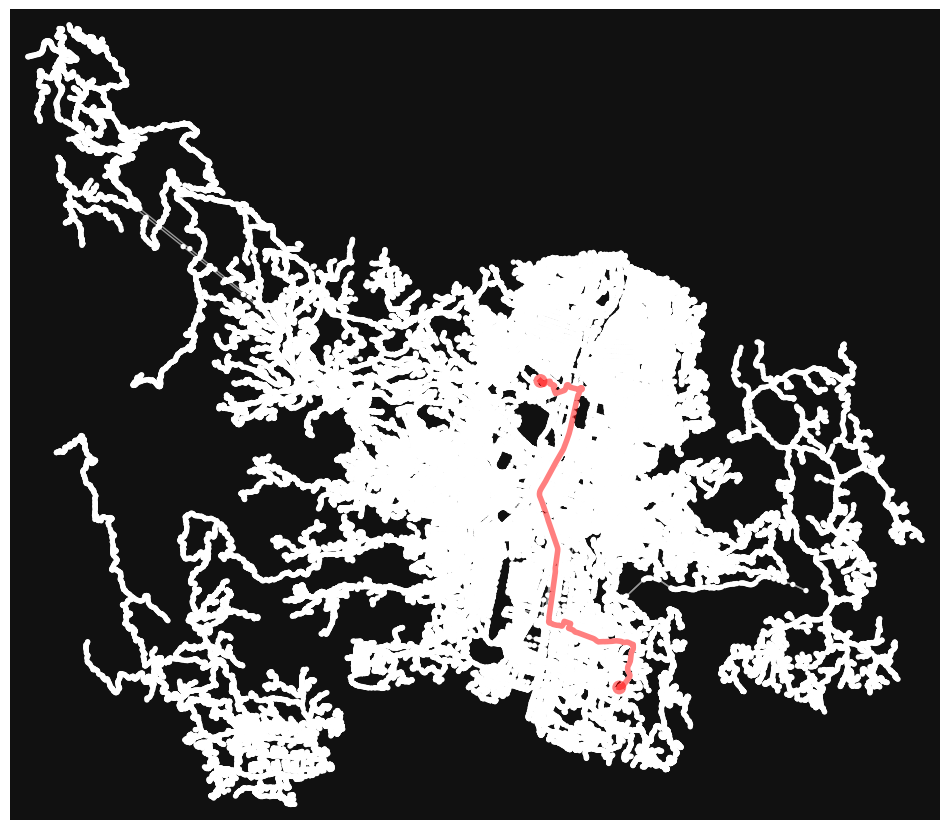

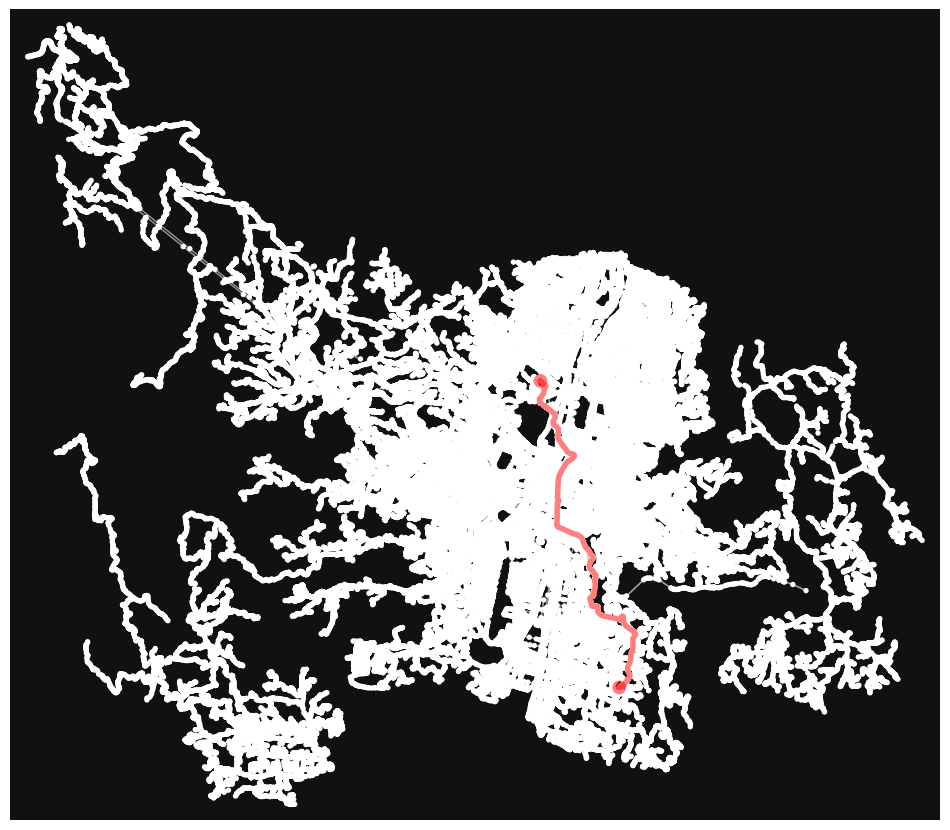

In [ ]:
Enrutamiento("Centro comercial el tesoro", "Hospital Pablo Tobón Uribe", trip_type="medical")

Tipo de viaje: MEDICAL
Modo MÉDICO: Priorizando hospitales y vías amplias
Ruta adaptativa (medical): 235 nodos
Ruta normal: 346 nodos
Peso total adaptativo: 6929.58
Peso total original: 5976.26


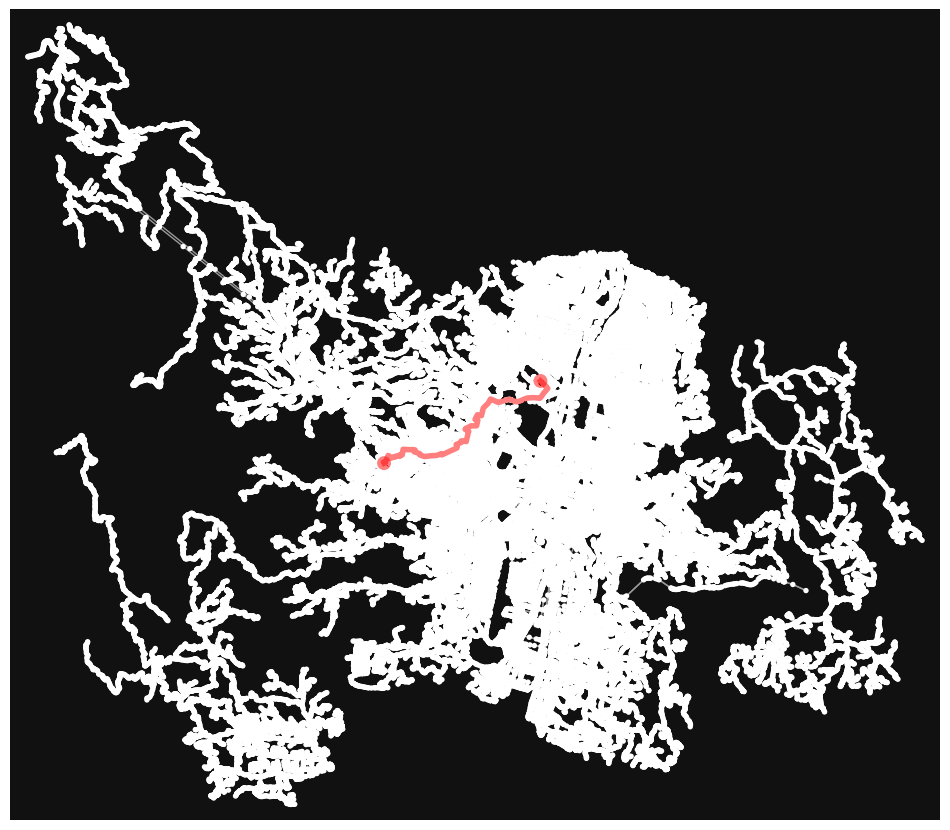

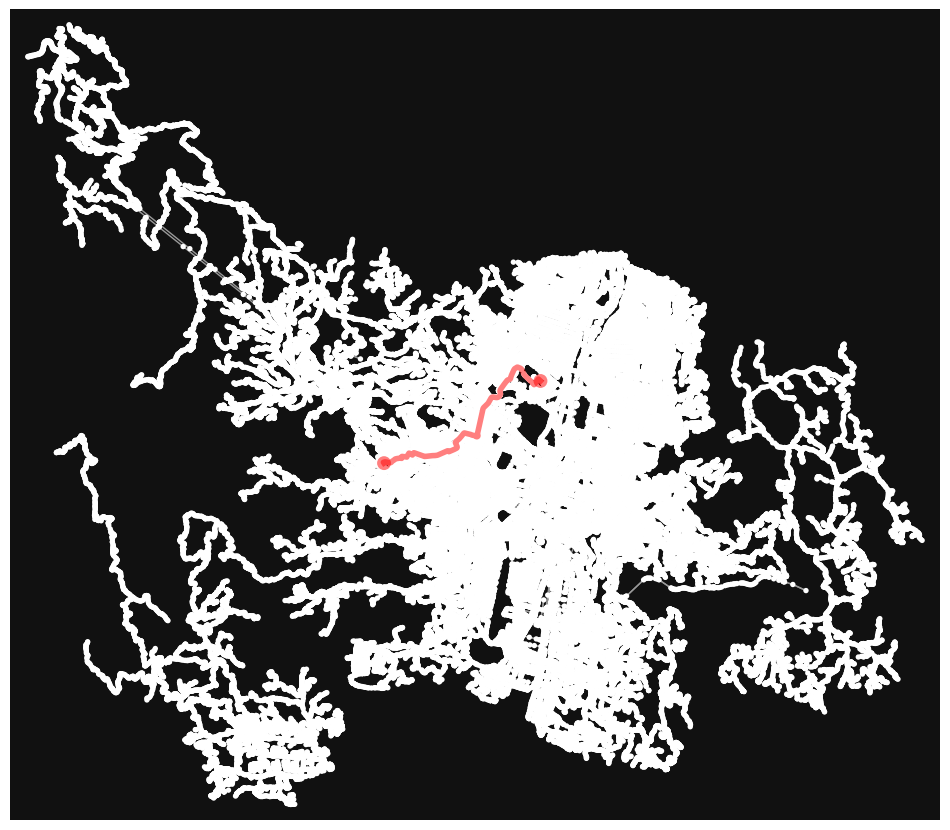

In [130]:
interactive_routing("Comuna 13", "Hospital Pablo Tobón Uribe", trip_type="medical")

Tipo de viaje: FAMILY
Modo FAMILIAR: Evitando zonas industriales, prefiriendo seguridad
Ruta adaptativa (family): 207 nodos
Ruta normal: 240 nodos
Peso total adaptativo: 4616.80
Peso total original: 4169.34


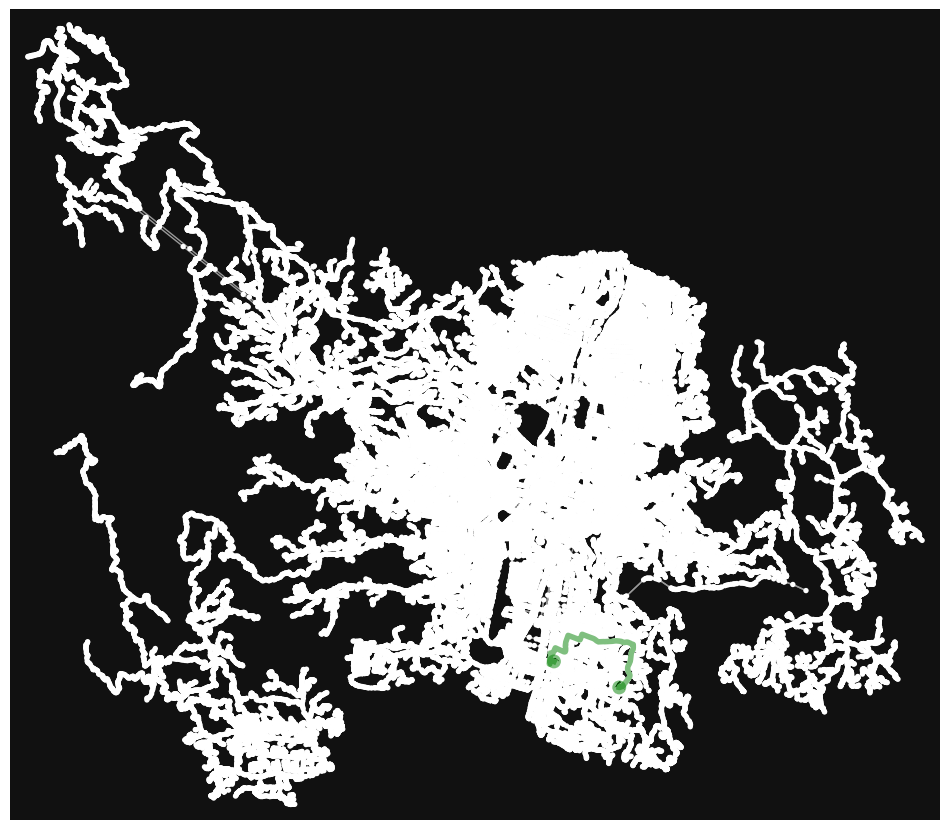

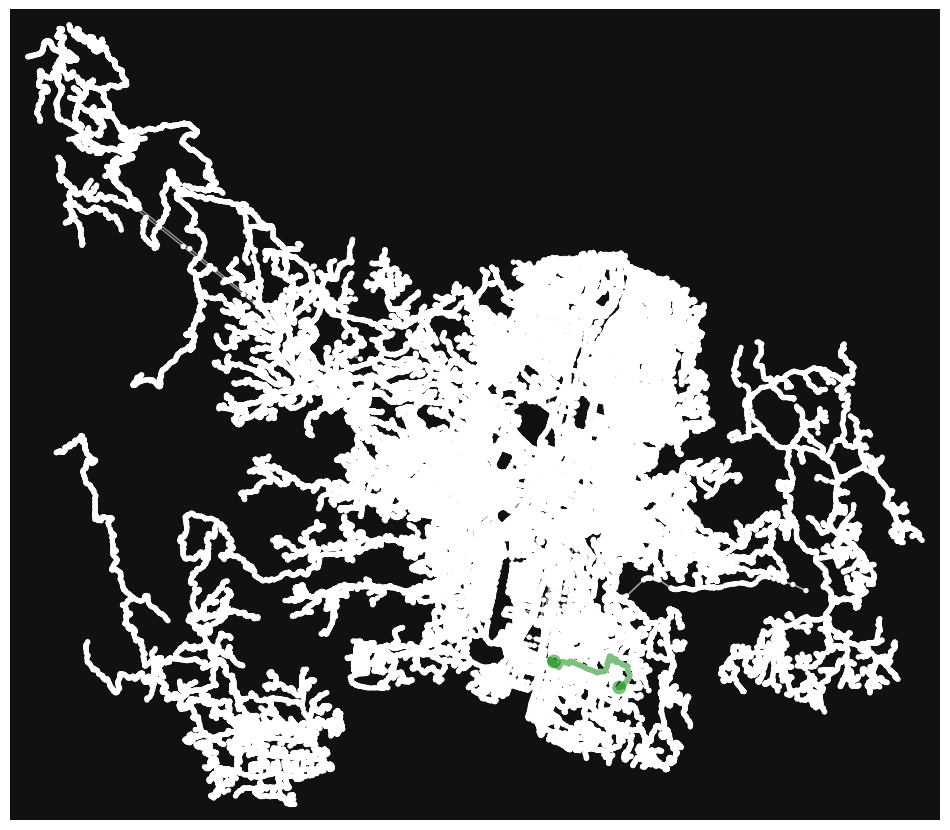

In [131]:
interactive_routing("Centro comercial el tesoro", "Clinica las vegas", trip_type="family")

#### 6 Funciones complementarias 

1. Grafica de las superficies

In [32]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors
# import osmnx as ox

# # Extraer los tipos únicos de superficie para asignar colores
# surfaces = list(gdf_edgesMod['surface'].fillna('unknown').unique())
# surfaces.sort()

# # Crear un mapa de colores personalizado
# color_map = plt.get_cmap("tab20", len(surfaces))
# surface_color_dict = {surf: color_map(i) for i, surf in enumerate(surfaces)}

# # Asignar color a cada arista según su superficie
# edge_colors = gdf_edgesMod['surface'].fillna('unknown').map(surface_color_dict)

# # Dibujar el grafo
# fig, ax = ox.plot_graph(Gsurface,
#                         edge_color=edge_colors.tolist(),
#                         edge_linewidth=3,
#                         node_size=0,
#                         bgcolor='white',
#                         figsize=(30, 30))

# # Mostrar leyenda aparte (opcional)
# legend_patches = [plt.Line2D([0], [0], color=surface_color_dict[surf], lw=3, label=surf) for surf in surfaces]
# plt.figure(figsize=(10, 5))
# plt.legend(handles=legend_patches, loc='center', ncol=4, frameon=False)
# plt.axis('off')
# plt.show()


In [19]:
for u, v, data in Gsurface.edges(data=True):
    print(medical_emergency_weight(u, v, data))


19.310466525532465
73.03537098753127
21.851354198793203
19.310466525532465
86.40921008251871
33.810179917210505
73.03537098753127
21.230025174210905
21.851354198793203
9.701505026329421
21.230025174210905
20.305447090892045
82.73071351477662
19.224148449297356
20.305447090892045
82.73071351477662
19.965283067451722
21.476766974275417
20.711606237407896
50.658630410880995
21.476766974275417
20.711606237407896
21.23766305947113
23.199453584890982
358.05493426400625
103.89589555216713
57.080881102023056
358.05493426400625
27.40313080595338
57.080881102023056
27.62074730715632
27.40313080595338
49.53673061176719
22.694307883730396
24.671136200098758
49.53673061176719
22.694307883730396
8.697221123416258
17.732424974120853
25.320394520464323
15.533086665331595
17.732424974120853
25.320394520464323
27.348644019627745
14.359931335552105
15.374921616491505
15.114840017468396
14.359931335552105
15.374921616491505
19.457480938902307
49.6712140263974
31.144882795031975
28.030664837169684
49.67121

In [ ]:
edges_to_check = list(Gsurface.edges(data=True))[:10]  

print("Comparación de pesos:")
for u, v, data in edges_to_check:
    peso_base = data.get('length', 1)  # peso original
    peso_medical = medical_emergency_weight(u, v, data)
    print(f"Arista ({u}, {v}): base={peso_base:.2f}, medical={peso_medical:.2f}")


Comparación de pesos:
Arista (309313450, 414940715): base=24.14, medical=19.31
Arista (309313450, 440765240): base=91.29, medical=73.04
Arista (414940715, 309313451): base=27.31, medical=21.85
Arista (414940715, 309313450): base=24.14, medical=19.31
Arista (440765240, 440765238): base=43.20, medical=86.41
Arista (440765240, 5324852837): base=42.26, medical=33.81
Arista (440765240, 309313450): base=91.29, medical=73.04
Arista (309313451, 414940727): base=26.54, medical=21.23
Arista (309313451, 414940715): base=27.31, medical=21.85
Arista (414940727, 9400446431): base=12.13, medical=9.70
